In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb
import wandb
wandb.login()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
images = np.load('drive/MyDrive/images.npy') # путь до картинок из иглу
images = np.transpose(images,(0,3,1,2))
images = torch.Tensor(images)
train_dataset = images

In [4]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [100000, 13873])
# test_set = CIFAR10(root='data', train=False, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
# test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
latent_dims = 2
variational_beta = 1

In [17]:
class VisualEncoder(nn.Module):
    def __init__(self, features_dim=2):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  # (3, 64, 64) -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), #             -> (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), #             -> (64, 3, 3)
            nn.ReLU(),
            nn.Flatten(),
        )

        n_flatten = 1024
        self.fc_mu = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
        self.fc_logvar = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, x):
        x = self.cnn(x)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class VisualDecoder(nn.Module):
    def __init__(self, features_dim=2):
        super().__init__()

        n_flatten = 1024
        self.linear = nn.Sequential(nn.Linear(features_dim, n_flatten), nn.ReLU())

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3,stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0,output_padding=1),
            # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8,stride=4, padding=0),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 64, 4, 4)
        x = self.cnn(x)
        return x 

In [18]:
class Autoencoder(nn.Module):
  def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
    super().__init__()
    self.encoder = encoder_class()
    self.decoder = decoder_class()
  def forward(self, x):
    latent_mu, latent_logvar = self.encoder(x)
    latent = self.latent_sample(latent_mu, latent_logvar)
    decode = self.decoder(latent)
    return decode, latent_mu, latent_logvar

  def latent_sample(self, mu, logvar):
    if self.training:
      # the reparameterization trick
      std = logvar.mul(0.5).exp_()
      eps = torch.empty_like(std).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x.view(-1, 12288), x.view(-1, 12288), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence
model = Autoencoder()
model.to('cuda')

Autoencoder(
  (encoder): VisualEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): ReLU()
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): ReLU()
    )
  )
  (decoder): VisualDecoder(
    (linear): Sequential(
      (0): Linear(in_features=2, out_features=1024, bias=True)
      (1): ReLU()
    )
    (cnn): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(32, 3, kernel_size=(8, 8), s

In [ ]:
# config_defaults = {
#     'epochs': 10,
#     'batch_size': 256,
#     'learning_rate': 1e-3,
#     'optimizer': 'adam',
#     'model': 'VisualEncoder'
#     }
# wandb.init(project='test_try', entity='neuro_ai',config=config_defaults)
# config = wandb.config
# config = config_defaults
# optimizer = optim.Adam(model.parameters(), config.learning_rate)
optimizer = optim.Adam(model.parameters(), 1e-3)
criterion = torch.nn.MSELoss()
for epoch in range(150):
  #train
  model.train()
  # train_loss = []
  for data in train_loader:
    data/=255
    data = data.to('cuda')
    image_batch_recon, latent_mu, latent_logvar = model(data)
    loss = vae_loss(image_batch_recon, data, latent_mu, latent_logvar)
    # train_loss.append(loss.item())
    # wandb.log({"train_loss":loss})
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # train_loss = np.array(train_loss).mean()
  #evaluate
  # model.eval()
  # val_loss = []
  # for data in val_loader:
  #     data/=255
  #     data = data.to('cuda')
  #     image_batch_recon, latent_mu, latent_logvar = model(data)
  #     loss = vae_loss(image_batch_recon, data, latent_mu, latent_logvar)
  #     val_loss.append(loss.item())
  # val_loss = np.array(val_loss).mean()
  # wandb.log({'val_loss': val_loss})
  print(loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(182869.4688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(182229.7344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(181540.6562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(174676.3906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(181510.0625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(190556.3594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(168967.1094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(179564.3906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187187.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(182834.2656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(178059.5469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(195593.0469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(169751.4531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(170947.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184578.3594, device='cuda:0', grad_fn=<AddBackward0>)
tensor(166036.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(178036.5938, devi

In [ ]:
torch.save(model.encoder,'encoder_model.pth')

In [ ]:
torch.save(model.state_dict(), 'autoencoder_weights.pth')
torch.save(model,'autoencoder_model.pth')
torch.save(model.encoder.state_dict(),'encoder_weigths.pth')

In [ ]:
torch.load('encoder_model.pth')

VisualEncoder(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
)

In [14]:
for data in train_loader:
  print(data.shape)
  data = data.to('cuda')
  tensor_to_pil = transforms.ToPILImage()(data[24,:,:,:].squeeze_(0)/255)
  image_batch_recon, latent_mu, latent_logvar = model(data/255)
  predict_to_pil = transforms.ToPILImage()(image_batch_recon[24,:,:,:].squeeze_(0))
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 64, 64])


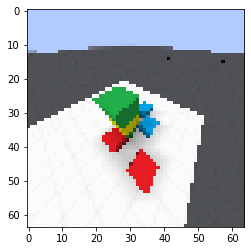

In [15]:
plt.imshow(tensor_to_pil)

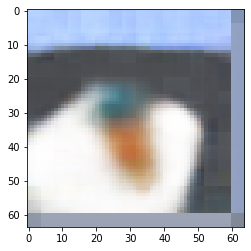

In [16]:
plt.imshow(predict_to_pil)